In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from bepsf.image import *
from bepsf.psfmodel import *
from bepsf.utils import *
from bepsf.infer import *

In [2]:
import matplotlib.pyplot as plt
import corner
import pandas as pd
from arviz import plot_trace
from jax.config import config
config.update('jax_enable_x64', True)

In [3]:
plt.rcParams['figure.dpi'] = 100

## simulate image

In [4]:
def simulate_image(Npix, Nsource, source_sigma, obserror_sigma, super_true):
    image_obs = PixelImage(Npix, Npix)
    image_super = PixelImage(Npix, Npix, dx=1./super_true, dy=1./super_true)
    print ("observed image shape:", image_obs.shape)
    print ("supersampled image shape:", image_super.shape)
    
    np.random.seed(124)
    fluxes = 10**np.random.rand(Nsource)
    xcenters = np.random.rand(Nsource) * image_super.xmax
    ycenters = np.random.rand(Nsource) * image_super.ymax
    
    # assumes common noise, but should be \propto sqrt(flux) in reality?
    np.random.seed(123)
    image_err = np.ones(image_obs.shape) * obserror_sigma
    Zerr = image_err * np.random.randn(*image_obs.shape)
    image_super.Z = np.zeros_like(image_super.X)
    for f, x, y in zip(fluxes, xcenters, ycenters):
        image_super.Z += gaussian_PSF(image_super.X, image_super.Y, f, x, y, source_sigma)*image_super.ds
    
    image_obs.Z = super_to_obs(image_super.Z, image_obs.X) + Zerr
    image_obs.Zerr = image_err
    
    return image_obs, image_super, fluxes, xcenters, ycenters

In [5]:
Npix = 30*3
Nsource = 10
supersample_true = 3.
source_sigma = 1.
source_half_extent = 3.5
obserr_sigma = 2e-3

In [6]:
image_obs, image_super, fluxes, xcenters, ycenters = simulate_image(Npix, Nsource, source_sigma, obserr_sigma, supersample_true)

observed image shape: (90, 90)
supersampled image shape: (270, 270)


## image mask

In [7]:
image_obs.define_mask(xcenters, ycenters, source_half_extent)

## initial guess for positions and fluxes

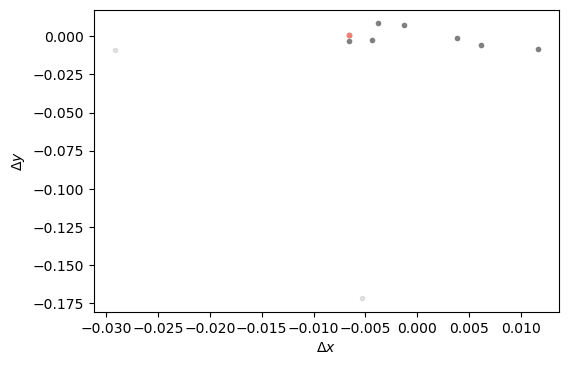

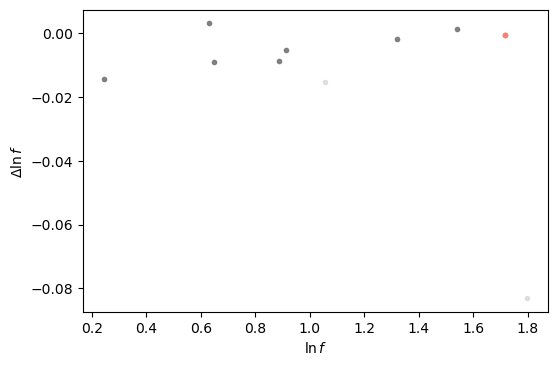

In [8]:
fap, xap, yap = image_obs.aperture_photometry(xcenters, ycenters, source_half_extent)
image_obs.lnfinit = np.log(np.array(fap))
image_obs.xinit = xap
image_obs.yinit = yap
image_obs.idx_anchor = choose_anchor(image_obs, xcenters, ycenters, lnfluxes=np.log(fluxes), 
                                     plot=True, mad_threshold=10)

### make sure that the anchor is an isolated source and is not around the edge

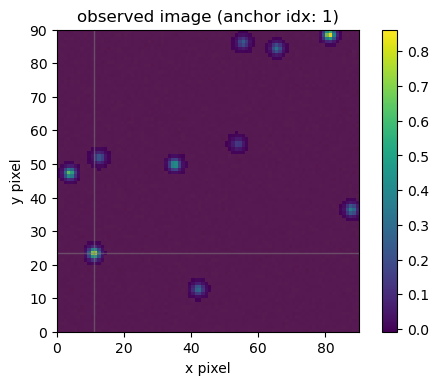

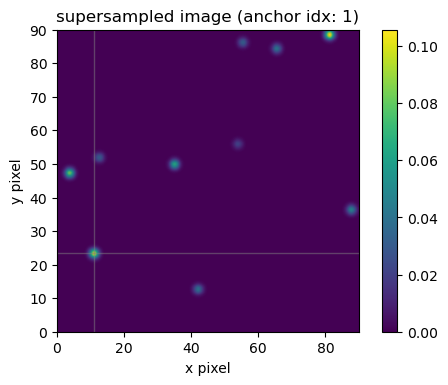

In [9]:
check_anchor(image_obs, image_super=image_super)

## define grid PSF model

In [10]:
psf_full_extent = source_half_extent*2
dx, dy = 1./5., 1./5.
gridpsf = GridePSFModel(psf_full_extent, psf_full_extent, dx, dy)

PSF grid shape: (35, 35)
grid edge: x=[-3.500000, 3.500000], y=[-3.500000, 3.500000]
grid center: x=0.000000, y=0.000000


## optimization

In [11]:
%%time
res = optimize(gridpsf, image_obs, xyclim=[-source_half_extent, source_half_extent])
popt, state = res
popt = drop_anchor(popt, image_obs.idx_anchor)

# optimizing flux and position...
ScipyMinimizeInfo(fun_val=DeviceArray(-1460.19555134, dtype=float64), success=True, status=1, iter_num=14)

# optimizing GP parameters...
ScipyMinimizeInfo(fun_val=DeviceArray(-1609.22842115, dtype=float64), success=True, status=0, iter_num=7)

# optimizing all parameters...
ScipyMinimizeInfo(fun_val=DeviceArray(-1609.39567018, dtype=float64), success=True, status=1, iter_num=11)
CPU times: user 6.05 s, sys: 2.5 s, total: 8.55 s
Wall time: 4.66 s


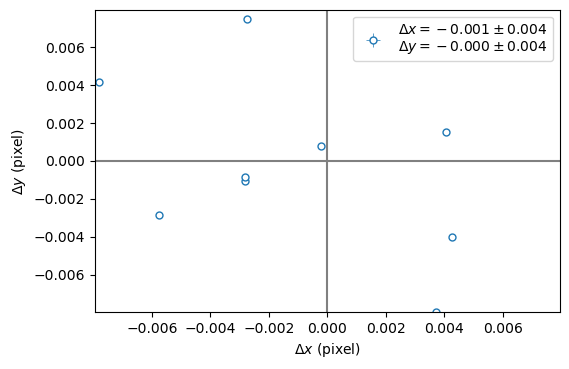

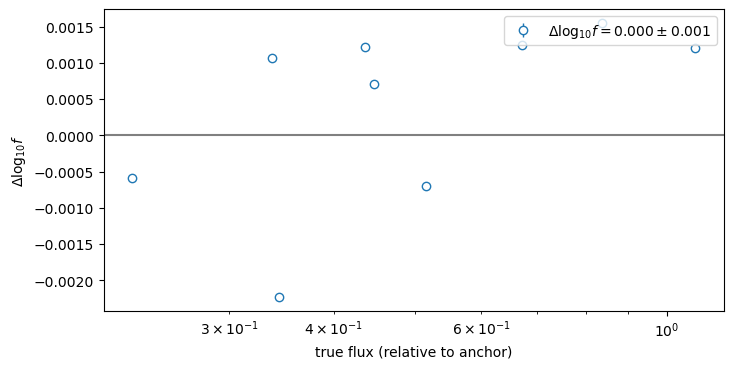

In [12]:
check_solution(image_obs, xcenters, ycenters, fluxes, p=popt)

In [13]:
mask1d = image_obs.mask1d
epsf1d_pred, _image1d_pred = gridpsf.predict_mean(popt['fluxes'], popt['xcenters'], popt['ycenters'], 
                            jnp.exp(popt['lnlenx']), jnp.exp(popt['lnleny']), jnp.exp(2*popt['lnamp']), jnp.exp(popt['lnmu']),
                            image_obs.X1d[~mask1d], image_obs.Y1d[~mask1d], image_obs.Z1d[~mask1d], image_obs.Zerr1d[~mask1d])
image1d_pred = np.zeros(image_obs.size)
image1d_pred[~mask1d] = _image1d_pred

In [14]:
ds = 0.05
x_offset = image_obs.xinit[image_obs.idx_anchor] - xcenters[image_obs.idx_anchor]
y_offset = image_obs.yinit[image_obs.idx_anchor] - ycenters[image_obs.idx_anchor]
finegrid = GridePSFModel(psf_full_extent, psf_full_extent, dx=ds, dy=ds)
epsf_pred = gridpsf.evaluate_ePSF(finegrid.X, finegrid.Y, x_offset, y_offset, epsf1d_pred)
true_epsf = compute_epsf(finegrid, gaussian_PSF, {"norm": 1., "xc": 0, "yc": 0, "sigma": source_sigma})

PSF grid shape: (141, 141)
grid edge: x=[-3.525000, 3.525000], y=[-3.525000, 3.525000]
grid center: x=0.000000, y=0.000000


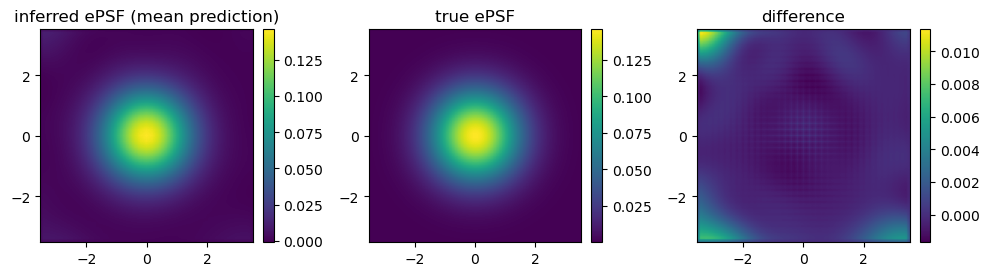

In [15]:
check_ePSF_fit(finegrid, epsf_pred/np.sum(epsf_pred)/finegrid.ds, true_epsf/np.sum(true_epsf)/finegrid.ds)

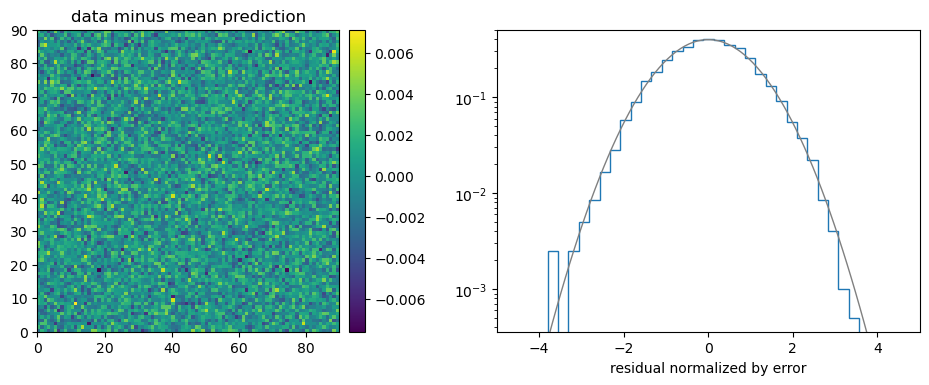

In [16]:
check_image_fit(image_obs, image1d_pred)

## run HMC

In [17]:
mcmc = run_hmc(gridpsf, image_obs, popt)

  0%|                                                                                                              | 0/1000 [00:00<?, ?it/s]/home/masuda/anaconda3/lib/python3.9/site-packages/jax/_src/tree_util.py:200: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
sample: 100%|████████████████████████████████████████████████| 1000/1000 [01:37<00:00, 10.21it/s, 15 steps of size 2.97e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]      1.27      0.01      1.27      1.26      1.29    997.98      1.00
      f[1]      3.74      0.01      3.74      3.73      3.76    781.41      1.00
      f[2]      2.87      0.01      2.87      2.85      2.88    795.53      1.00
      f[3]      2.43      0.01      2.43      2.42      2.44    708.16      1.00
      f[4]      1.88      0.01      1.88      1.87      1.89    707.61      1.00
      f[5]      4.67      0.01      4.67      4.65      4.69    728.00      1.00
      f[6]      2.49      0.01      2.49      2.48      2.50    580.31      1.00
      f[7]      1.90      0.01      1.90      1.89      1.91    829.49      1.00
      f[8]      6.04      0.01      6.04      6.02      6.06    508.50      1.00
       lna     -3.59      0.14     -3.59     -3.84     -3.38    519.60      1.00
    lnlenx      0.32      0.04      0.33      0.25      0.38    463.17      1.00
    lnleny      0.31      0

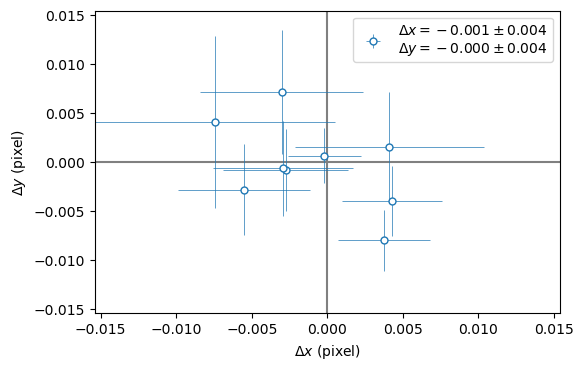

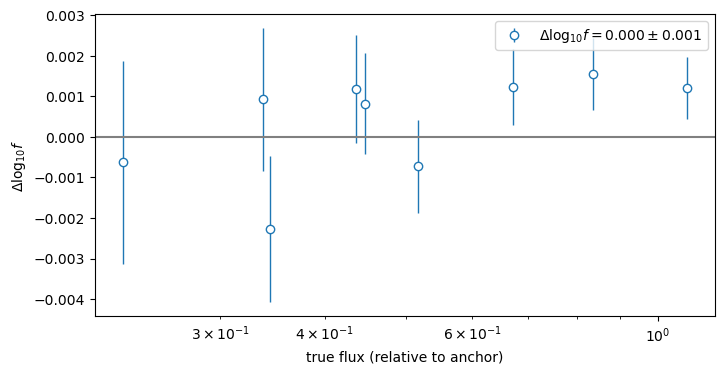

In [18]:
check_solution(image_obs, xcenters, ycenters, fluxes, samples=mcmc.get_samples())

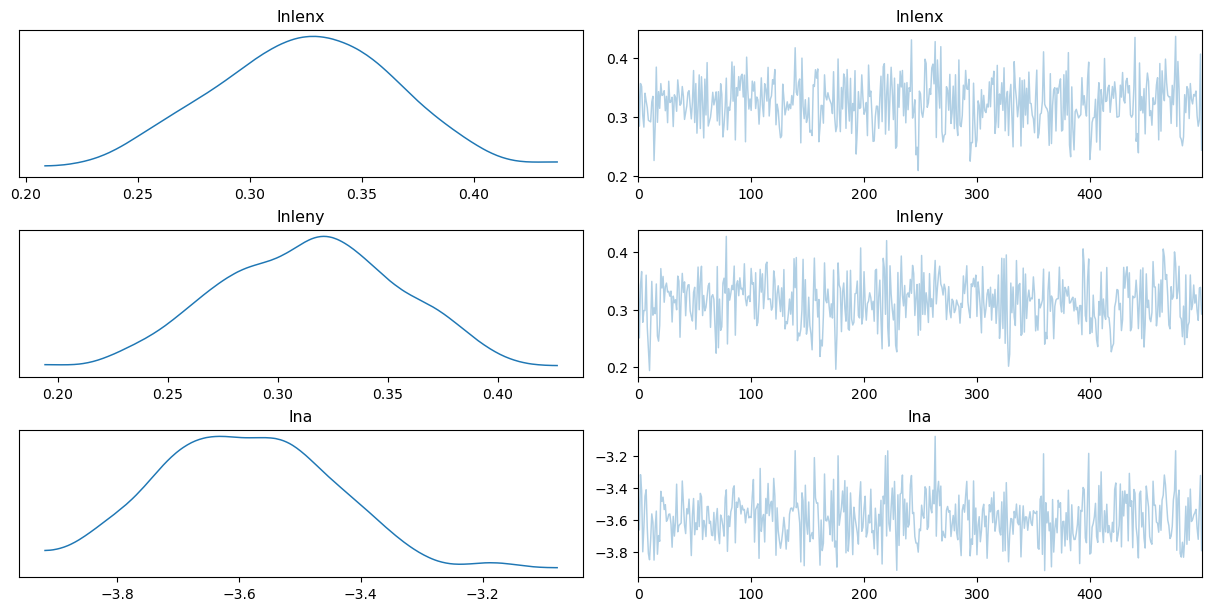

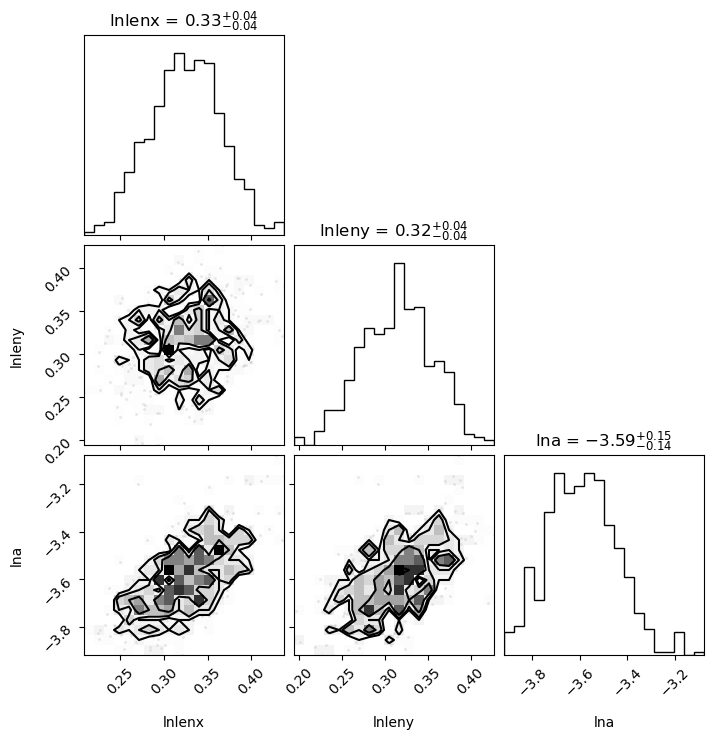

In [19]:
check_mcmc_hyperparameters(mcmc)